In [97]:
import numpy as np
import json
import cv2 as cv
import matplotlib.pyplot as plt
import string
import pandas as pd
import pytesseract as pt
import os
from fast_searcher import *
import concurrent.futures
from symspellpy import SymSpell, Verbosity
from difflib import SequenceMatcher
from PIL import Image

### Загрузка приложенного датасета

In [2]:
pathes = []
for path, _, files in os.walk('./data'):
    if len(files) == 0:
        continue

    t_pathes = [f'{path}\\' + file for file in files]
    pathes.append(t_pathes)

raw_pathes = []

for folder in pathes:
    for path in folder:
        raw_pathes.append(path)

In [3]:
pt.pytesseract.tesseract_cmd = "D:/Tools/Tesseract-OCR/tesseract.exe"

### Препроцессинг входного изображения

In [4]:
img = np.array(Image.open(raw_pathes[0])) # исходное изображение

if img.size // 300 // 3 < 1700:
   shape = (int(img.shape[0] * 1.3), int(img.shape[1] * 1.3))
   img = cv.resize(img, shape, fx=0, fy=0, interpolation=cv.INTER_CUBIC)

In [5]:
def image_preprocessing(src):
   gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
   blured1 = Image.fromarray(cv.medianBlur(gray, 3))
   blured2 = Image.fromarray(cv.medianBlur(gray, 51))
   divided = np.ma.divide(blured1, blured2).data
   normed = np.uint8(255 * divided / divided.max())
   th, threshold = cv.threshold(normed, 100, 255, cv.THRESH_OTSU)

   return threshold

1. Распознавание исходного текста на картинке с использованием библиотеки PyTesseract
2. Фильтрация выходных синтаксических токенов: выборка наиболее вероятных слов

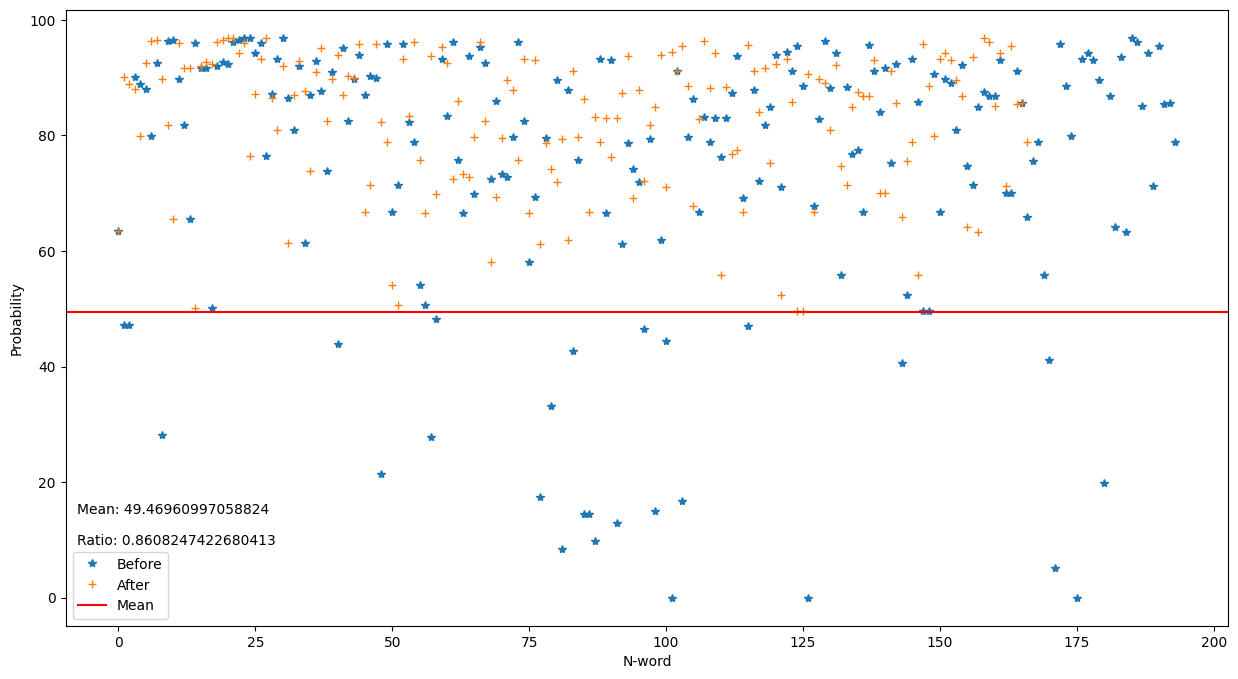

In [6]:
prepared_img = image_preprocessing(img)
data : pd.DataFrame = pt.image_to_data(prepared_img, lang='rus+eng', output_type=pt.Output.DATAFRAME, config=f'--psm 12')
data = data.dropna(subset=['text'])

len_before = data.shape[0]

mean = data['conf'].mean()
under_mean = data[data['conf'] <= mean]['conf'].mean()

fig, axs = plt.subplots(1,1,  figsize=(15, 8))
plt.plot(range(data.shape[0]), data['conf'], '*')

data = data[data['conf'] >= under_mean]
plt.plot(range(data.shape[0]), data['conf'], '+')
plt.axline((0, under_mean), (1, under_mean), color='red')

plt.legend(['Before', 'After', 'Mean'])
plt.xlabel('N-word')
plt.ylabel('Probability')

plt.text(.01, 0.15, f'Ratio: {data.shape[0] / len_before}', ha='left', va='top', transform=axs.transAxes)
plt.text(.01, 0.20, f'Mean: {under_mean}', ha='left', va='top', transform=axs.transAxes)
plt.show()

In [7]:
data

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
4,5,1,1,1,1,1,12,11,61,37,63.536713,(©
7,5,1,1,1,1,4,257,9,140,39,90.043457,МОЛОЧНАЯ
8,5,1,1,1,1,5,406,9,284,48,88.929489,БЫСТРОРАСТВОРИМАЯ
9,5,1,1,1,1,6,697,9,183,44,88.119751,ОБОГАЩЕННАЯ
13,5,1,2,1,1,1,13,58,275,39,79.848274,ПРОБИОТИЧЕСКИМИ
...,...,...,...,...,...,...,...,...,...,...,...,...
250,5,1,20,1,1,6,349,842,49,21,71.278236,MeCTE
251,5,1,20,1,1,7,405,842,19,21,95.560593,не
252,5,1,20,1,1,8,427,831,54,43,85.518234,более
253,5,1,20,1,1,9,488,843,41,28,85.596725,двух


In [8]:
' '.join(data['text'])

'(© МОЛОЧНАЯ БЫСТРОРАСТВОРИМАЯ ОБОГАЩЕННАЯ ПРОБИОТИЧЕСКИМИ КУЛЬТУРАМИ «КАША СУХАЯ МОЛОЧНАЯ  МУЛЬТИЗЛАКОВАЯ С ЯБЛОКОМ И БАНАНОМ, (СБИФИДОБАКТЕРИЯМИ, БЫСТРОРАСТВОРИМАЯ, ОБОГАЩЕННАЯ ВИТАМИНАМИИ МИНЕРАЛЬНЫМИ ВЕЩЕСТВАМИ» ДЛЯ ПИТАНИЯ ДЕТЕЙ РАННЕГО ВОЗРАСТА. C 6 МЕСЯЦЕВ COCTAB: нука (60,7 %) { пшеничная (50,5 %) (одержит гречневая (54%), овсяная (34%) (одержит глютен), рисовая кукурузная {1.7%}, молоко сухое обезжиренное (22%) низкозруковое рапсовое масло, хлолья банана (2,3%, хлолья яблока (1,5%) минеральные вещества (Кальция карбонат, железа (Il) фумарат, цинка сульфат, Нодид, калия} (C кислота, E ацетат, PP (никотинамид}, BS кальция}, А (ретинола ацетат}, (тнамина BG B2 В9 ( фолиевая кислота) D (3 холекальциферолр, бифидобактерии не менее 1x10* Изготовлено с использованием обезжиренного сухого молока, Продукт упакован в модифицированной C азотом. ИЗГОТОВИТЕЛЬ: 000 «Нестле Россия», 115054, Россия, г. Mockea, Павелецкая пл, д. 2, р. 1 Волокде: 160010, Россия, г. Волокда, ул. Михаила Поповича

### Загрузка лимитов

In [9]:
class Limit:
    def __init__(self, bad_contains : list[dict], bad_condition : list[dict]) -> None:
        self.bad_contains = bad_contains
        self.bad_condition = bad_condition


limits_path = './limits/'

files = []
for _, _, f in os.walk(limits_path):
    files = f

limits = {}
for file in files: # Загрузка лимитов из файлов
    path = limits_path + file
    limit = Limit(**json.loads(open(path, encoding='utf-8').read()))
    limits[file[:-5]] = limit

### Инициализация орфографических корректировщиков

In [ ]:
!wget http://dict.ruslang.ru/Freq2011.zip 
!tar -xf ./Freq2011.zip

os.remove('./Freq2011.zip')
os.remove('./freqrnc_readme.txt')
os.replace('./freqrnc2011.csv', './dict/freqrnc2011.csv')

Большой словарь русских слов во всех морфологических формах (1 531 464 записи) 

In [ ]:
!wget https://github.com/danakt/russian-words/raw/master/russian.txt
text = open('./russian.txt', encoding='windows-1251').read()
with open('./dict/russian.txt', 'w', encoding='utf-8') as w:
    w.write(text)

os.remove('./russian.txt')

In [10]:
dict_filename = './dict/russian.txt'
big_dict = pd.read_csv(dict_filename)

Частотный словарь русского языка

In [11]:
freq_filename = './dict/dict_ru.csv'
freq_dict = pd.read_csv('./dict/freqrnc2011.csv', sep='\t')
freq_dict['Freq(ipm)']=freq_dict['Freq(ipm)'].apply(func=math.ceil)
freq_dict.to_csv(freq_filename, sep=' ', index=False, header=False)

In [12]:
spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
spell.load_dictionary(freq_filename, term_index=0, count_index=2, encoding='utf-8')

True

Инициализация процессов для паралелльной обработки словаря

In [13]:
workers_cnt = 20
target, positions = init_data(dict_filename, 0.75, workers_cnt)
proc_bag = init_processbag(target, workers_cnt)

Initialize process bag


Это, мать вашу, лексический анализатор на минималках
```
Поддерживаемый алфавит:
1. [a-Z] + [а-Я]
2. [0-9]
3. [,]
```

In [54]:
class State:
    WS = 0
    Numerical = 1
    Word = 2
    EOF = 3
    Punc = 4
    Bad = 5

class Token():
    def __init__(self, text : str, kind : State, start_pos : int):
        self.text = text
        self.kind = kind
        self.start_pos = start_pos
    
    def __str__(self):
        return f'{self.text} {self.kind} {self.start_pos}'

class Lexer:
    def __init__(self, sentence : str) -> None:
        self.sentence = sentence
        self.__start_pos = 0
        self.__position = 0
        self.__end_pos = len(sentence)
        self.alphabet = set([i for i in (string.ascii_letters + 'АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюя')])
        self.__kind : State = None

    def __lookahead(self, cnt) -> str:
        return self.sentence[self.__position + cnt] if self.__position + cnt < self.__end_pos else self.sentence[-1]

    def __getCurrChar(self) -> str:
        return self.sentence[self.__position] if self.__position < self.__end_pos else '\0'

    def __lex(self):
        self.__start_pos = self.__position

        match self.__getCurrChar():
            case '0' | '1' | '2' | '3' | '4' | '5' | '6' | '7' | '8' | '9' :
                self.__lexNumericalToken()
            case ' ' | '\n' | '\r' | '\t':
                self.__lexWhiteSpaceToken()
            case ',':
                self.__kind = State.Punc
                self.__position += 1
            case '\0':
                self.__kind = State.EOF
            case _:
                if self.__getCurrChar() in self.alphabet:
                    self.__lexWordToken()
                else:
                    self.__kind = State.Bad
                    self.__position += 1
                
        span = self.sentence[self.__start_pos : self.__position]
        return Token(span, self.__kind, self.__start_pos)

    def __lexWordToken(self):
        while self.__getCurrChar() in self.alphabet:
            self.__position += 1

        self.__kind = State.Word

    def __lexWhiteSpaceToken(self):
        while self.__getCurrChar() in string.whitespace:
            self.__position += 1

        self.__kind = State.WS

    def __lexNumericalToken(self):
        while True:
            ch = self.__getCurrChar()
            if ch in string.digits:
                self.__position += 1
            elif ch == ',':
                if self.__lookahead(1) in string.digits:
                    self.__position += 1
                else:
                    break
            else:
                break
        
        self.__kind = State.Numerical

        
    def tokenize(self) -> list[Token]:
        tokens = []
        token = self.__lex()
        while token.kind != State.EOF:
            tokens.append(token)
            token = self.__lex()
        tokens.append(token)
        return tokens


Стоит также отметить, что служебные части речи и местоимения не несут никакой смысловой нагрузки. Поэтому, чтобы, теоретически, увеличить точность алгоритма, необходимо также отсеивать их.

In [138]:
def evaluate_weight(src_word, target_word):
    weight = 0
    min_len = min(len(src_word), len(target_word))
    for i in range(min_len):
        weight += min_len - i if src_word[i] == target_word[i] else 0
    
    weight -= abs(len(target_word) - len(src_word))

    return weight

def quick_search(word):
    suggestions = [sg.term for sg in spell.lookup(word, max_edit_distance=2, verbosity=Verbosity.CLOSEST)]
    if len(suggestions) == 0:
        return []
    
    weights = [evaluate_weight(word, s_word) for s_word in suggestions]
    best_weight = max(weights)
    return [term for i, term in enumerate(suggestions) if weights[i] == best_weight]


def heavy_search(word):
    suggestions = find_async(word, proc_bag, positions)
    if len(suggestions) == 0:
        return []

    weights = [evaluate_weight(word, s_word) for s_word in suggestions]
    best_weight = max(weights)
    return [term for i, term in enumerate(suggestions) if weights[i] == best_weight]


def lemmatization(word, priority_words : set[str], enable_heavy):
    suggestions = quick_search(word)
    if len(suggestions) == 0 and enable_heavy:
        suggestions = heavy_search(word)
    if len(suggestions) == 0:
        suggestions = [word]

    
    for sg in suggestions:
        if sg in priority_words:
            return sg
        
    return suggestions[0]
    

def normilize(src : str, priority_words : set[str], enable_heavy : bool = False) -> list[Token]: # Нормализация строки: удаление всякого ненужного говна
    blacklist = [chr(i) for i in range(33, 44)] + [chr(i) for i in range(45, 48)] + [chr(i) for i in range(58, 65)] + [chr(i) for i in range(91, 97)] + [chr(i) for i in range(123, 127)]
    bad_pos = set('spro apro advpro pr conj part intj init'.split())

    for ex in blacklist:
        src = src.replace(ex, '')

    src = src.lower()
    normilized : list[Token] = []
    tokens = Lexer(src).tokenize()

    for token in tokens:
        match token.kind:
            case State.Word:
                lemma = lemmatization(token.text, priority_words, enable_heavy) # лемматизация
                PoS = freq_dict[freq_dict['Lemma'] == lemma]['PoS'] # часть речи слова
                
                if PoS.__len__() == 0:
                    normilized.append(Token(lemma, token.kind, token.start_pos))
                    continue
                
                part = PoS.to_string(index=False)
                if part not in bad_pos:
                    new_token = Token(lemma, token.kind, token.start_pos) # добавляем лемматизированный токен
                    normilized.append(new_token)

            case State.Numerical:
                normilized.append(token)

    return normilized

In [ ]:
def find_nearest_num(words): # первое вхождение числа в строке
    for word in words:
        if any([(digit in word) for digit in string.digits]):
            return int(''.join([w for w in word if w in string.digits]))
    return None

def similarity(first, second): # процент схожести двух строк
    return SequenceMatcher(None, first, second).ratio()

def lex(sentence : str, keywords : list[str]): # анализ строки на наличие некоторого множества ключевых слов, затем поиск ближайших чисел к этим словам
    values = {}
    split = sentence.split()
    for i, word in enumerate(split):
        for keyword in keywords:
            if similarity(word, keyword) >= 0.7:
                num = find_nearest_num(split[i:i+3]) # поиск числа в следующих двух словах
                if num != None:
                    values[keyword] = num
                else:
                    values[keyword] = None
    

    for keyword in keywords: # присваивание дефолтных значений нераспознанным ключ. словам
        if keyword not in values.keys():
            values[keyword] = None
                
    
    return values

In [ ]:
class Category:
    def __init__(self, type, energy, natrium, sugar, protein, fat, fruits, calories) -> None:
        self.type = type
        self.energy = energy
        self.natrium = natrium
        self.sugar = sugar
        self.protein = protein
        self.fat = fat
        self.fruits = fruits
        self.calories = calories
        self.__arr = [energy, natrium, sugar, protein, fat, fruits, calories]

        self.limit_set = False
        self.limits = []
    
    def add_limit(self, limit : Limit): # У каждой категории может быть несколько лимитов
        self.limit_set = True
        self.limits.append(limit)
        return self
    
    def check_condition(self, energy, natrium, sugar, protein, fat, fruits, calories): # Алгоритм проверки удовлетворения условиям, заданным в таблице
        arr = [energy, natrium, sugar, protein, fat, fruits, calories]
        # 1 - <=, 2 - >=, 3 - 3<x<10
        opers = [2,1,1,3,1,1,2]
        answer = []
        for i, item in enumerate(arr):
            if item is None:
                continue

            match opers[i]:
                case 1: 
                    answer.append(arr[i] <= self.__arr[i])
                case 2:
                    answer.append(arr[i] >= self.__arr[i])
                case 3:
                    answer.append(3 <= arr[i] <= 10)
        
        return all(answer) if len(answer) != 0 else True
    
    
    def check_limits(self, sentence): # Алгоритм проверки лимитов
        if not self.limit_set:
            raise Exception('Limit entity is null')

        limits_res = []
        for limit in self.limits:
            cond_result = []
            cont_result = []

            for cond in limit.bad_condition: # Плохие условия
                name, val = cond[0], cond[1]
                token = lex(sentence, keywords=[name])
                cond_result.append(token[name] != val)

            split = sentence.split()
            for cont in limit.bad_contains: # Плохой состав
                temp = []

                for word in split:
                    temp.append(similarity(cont, word) <= 0.7)

                cont_result.append(all(temp))

            limits_res.append(all([all(cond_result), all(cont_result)]))

        return all(limits_res)

In [ ]:
categories : list[Category] = []
categories.append(Category('1',   80, 50, 0,  5.5, 3.3, 10,  30).add_limit(limits['porridge']))
categories.append(Category('2',   60, 50, 0,  0,   4.5, 5,   40).add_limit(limits['milk']))
categories.append(Category('3.1', 60, 50, 0,  0,   4.5, 0,   30).add_limit(limits['fruits']).add_limit(limits['vegeb']))
categories.append(Category('4.1', 60, 50, 15, 3,   4.5, 5,   0))
categories.append(Category('4.2', 60, 50, 15, 3,   6,   5,   0))
categories.append(Category('4.3', 60, 50, 15, 3,   4.5, 5,   0))
categories.append(Category('4.4', 60, 50, 15, 4,   6,   5,   0))
categories.append(Category('4.5', 60, 50, 15, 7,   6,   5,   0))
categories.append(Category('5.1', 50, 50, 0,  0,   4.5, 100, 30))
categories.append(Category('5.2', 50, 50, 15, 5.5, 4.5, 0,   0))

In [ ]:
default_keywords = [
    'энергетическая',
    'натрий',
    'сахар',
    'белок',
    'жир',
    'фрукт',
    'калории'
]

product_class = '1' # класс продукта (1, 2, 3.1, 4.1, ...). Для изображение ex1 - каша
category = None
for categ in categories:
        if categ.type == product_class:
              category = categ
              break

In [ ]:
# Раскомментируйте строки, чтобы проэкспериментировать с разными случаями: ограничения на наличие в составе какого-то вещества
# или табличные ограничения на количество какого-то вещества 

#normilized_blocks[3] = ''
#normilized_blocks[3] = 'фруктовое калл 100%'
#normilized_blocks[3] = 'белки ае 120г'
#normilized_blocks[3] = 'белки муу 5г жир кеек 3г аващное пюре 100%'

validations = []
shit = []
for token in normilized_tokens:
    vals = lex(token, default_keywords) 
    cond_table = category.check_condition(vals['энергетическая'],
                                                vals['натрий'], 
                                                vals['сахар'], 
                                                vals['белок'], 
                                                vals['жир'], 
                                                vals['фрукт'], 
                                                vals['калории'])
    
    limit_valid = True
    if category.limit_set:
        limit_valid = category.check_limits(token)


    if not cond_table:
        print('Issues with table condition')
        shit.append((1, token))
    if not limit_valid:
        print("Issues with contains limits")
        shit.append((2, token))

shit